In [159]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
import requests
import joblib
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Hazel and Bazel Hospital

The Hazel and Bazel Hospital, in Los Angeles, California, has contacted us regarding suspicion of malpractice and is currently under investigation by the Fair Medical Practices Bureau. Situations have come to light where patients have been wrongfully medically discharged, resulting in severe health consequences for the patient. Our main objective is to identify patients who are likely to return to the hospital in less than 30 days, for which the hospital might be liable for wrongful discharge before due time.  

The reasons for this are still unknown, and investigation into this matter is required. It is unknown if this is a demographic-specific issue or specific to any of the medical specialities/services. Additionally, they want us to create and deploy a REST API endpoint for patient discharge verification. This will be integrated directly into the hospital’s system to be triggered every time the medical dismissal information for a patient is filled in in their system. You will be responsible for setting this system up and running it for a year.	

They ask you to provide a service that they can call, with two endpoints. 
Predict: to which they will send requests for new predictions
Update: to which they will send the actual information if a person should or should not have been discharged

The hospital staff will use those endpoints to do several rounds of tests and pick the first 10 teams based on a mix of F1-score and the fairness requirement. Those teams will be called on to present their service and model.  


# Objective

In this hackathon, you will tackle a binary classification problem setup in a real-world scenario. As described in the previous sections, this problem will consist of predicting, based on a number of features, if a person should or should not be discharged. Some of these features are considered sensitive - such as race and gender - and will need special attention to avoid discriminating against minorities.

You will be given an initial dataset with a number of examples. You should use this dataset to build a model, taking into account the different requirements the client posed, in particular:

You want to maximize the percentage of correct predictions
Your model should not yield differences among gender or race as measured by the difference in the above metric by more than 0.15

The dataset contains the following fields. The field that you must use as outcome is:
readmitted


With this in mind, you should set up a server that serves this model, with two endpoints, described below:


# Import the data

In [2]:
pwd

'/Users/fabienguegan/projects/batch6-workspace/S06 - DS in the Real World/HCKT06 - DS in the Real World'

In [897]:
df = pd.read_csv(os.path.join("data", "train.csv"), index_col=0)
df

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
62479,62479,46826964,White,Male,[80-90),?,3.0,1.0,1,2,...,A-,16.0,False,NONE,None,No,No,No,No,No
4543,4543,57647952,Caucasian,Male,[40-50),?,6.0,25.0,17,4,...,O+,14.2,False,>200,None,No,Yes,No,Yes,No
61307,61307,73513008,European,Female,[30-40),?,2.0,1.0,7,2,...,O+,12.7,False,None,None,No,Yes,No,Yes,No
43014,43014,204181182,Caucasian,Female,[40-50),?,1.0,6.0,7,3,...,O+,12.3,False,None,None,No,Yes,Ch,Yes,Yes
64051,64051,47947464,AfricanAmerican,Male,[70-80),?,1.0,11.0,5,6,...,O+,13.5,False,None,None,No,Yes,Ch,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55397,55397,125169948,Caucasian,Male,[50-60),?,5.0,1.0,1,3,...,AB+,15.2,False,NONE,None,No,No,No,No,No
74481,74481,46468368,Black,Female,[60-70),?,1.0,6.0,7,7,...,A-,13.3,False,None,None,No,Yes,Ch,Yes,No
46182,46182,196276608,AfricanAmerican,Female,[60-70),?,2.0,6.0,4,8,...,O+,13.7,True,None,None,No,Yes,No,Yes,No
77592,77592,149913090,Caucasian,Male,[50-60),?,1.0,6.0,7,3,...,B+,14.5,False,None,None,No,No,No,No,No


In [565]:
df.columns

Index(['admission_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [566]:
# 'admission_id', 'patient_id' --> not releveant columns 


# other columns
# Weight has a lot of ? (9000 out of 10000) --> drop the column

# gender --> 1 Unknown/Invalid we caan drop it

# age --> 276 null  (we can maybe drop it)

# race --> 209 "?" and need to group (white, WHITE, caucasian and European) , 
# (AfricanAmerican, Afro American, African American, AfricanAmerican, AFRICANAMERICAN)
# (Latino, Hispanic)


## admission_type_code, discharge_disposition_code, admission_source_code --> should be category!!!

# admission_type_code --> 144 null, code 5 =458, code 6=503, code 8= 19 (this code should be all together with null)
# discharge_disposition_code --> 70 null, code 18= 360, code 25= 106, code 26 = 0 (all together)
# admission_source_code --> 0 null, code 17 = 665, code 20 = 25, code 21 = 0 (all together)

# complete_vaccination_status --> 0 null but 46 "None"
# num_lab_procedures --> 200 null
# num_medications --> 319 null

# diag_1 --> a lot of categories for onehot encoding
# diag_2 --> a lot of categories for onehot encoding (and 158 null)
# diag_3 --> a lot of categories for onehot encoding

# max_glu_serum --> need to change NONE or None and NORM or Norm


# Data analysis and EDA

## unbalanced target 

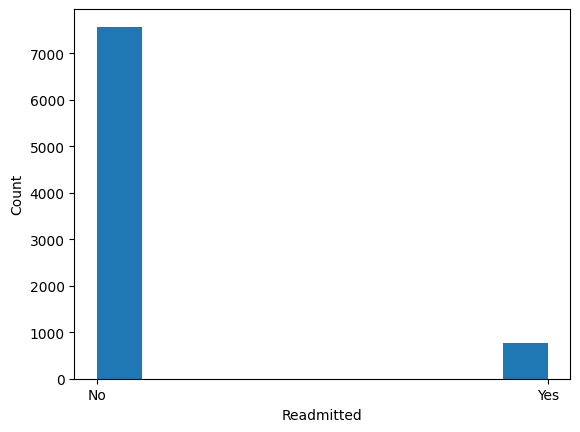

In [896]:
plt.hist(df["readmitted"])
plt.xlabel("Readmitted")
plt.ylabel("Count")
plt.show()

## Modify the features 

In [833]:
df = df.copy()

In [834]:
# 'admission_id', 'patient_id' --> not releveant columns 


# other columns
# Weight has a lot of ? (9000 out of 10000) --> drop the column

# gender --> 1 Unknown/Invalid we caan drop it

# age --> 276 null  (we can maybe drop it)

# race --> 209 "?" and need to group (white, WHITE, caucasian and European) , 
# (AfricanAmerican, Afro American, African American, AfricanAmerican, AFRICANAMERICAN)
# (Latino, Hispanic)


## admission_type_code, discharge_disposition_code, admission_source_code --> should be category!!!

# admission_type_code --> 144 null, code 5 =458, code 6=503, code 8= 19 (this code should be all together with null)
# discharge_disposition_code --> 70 null, code 18= 360, code 25= 106, code 26 = 0 (all together)
# admission_source_code --> 0 null, code 17 = 665, code 20 = 25, code 21 = 0 (all together)

# complete_vaccination_status --> 0 null but 46 "None"
# num_lab_procedures --> 200 null
# num_medications --> 319 null

# diag_1 --> a lot of categories for onehot encoding
# diag_2 --> a lot of categories for onehot encoding (and 158 null)
# diag_3 --> a lot of categories for onehot encoding

# max_glu_serum --> need to change NONE or None and NORM or Norm

### drop 'admission_id', 'patient_id' columns

In [835]:
# First we need to drop the duplicate from patient_id

In [836]:
df.patient_id.nunique(), len(df)

(9446, 10000)

In [837]:
# Create a boolean mask indicating which rows have duplicated patient_id values
mask = df.duplicated(subset='patient_id', keep=False)

In [838]:
# Use boolean indexing to select the rows to keep
df = df[~mask]

In [839]:
# Now we can remove the 'admission_id', 'patient_id' columns because they don't provide any information to the model

In [840]:
df = df.drop(columns=['admission_id', 'patient_id'])

## Drop the weight column

In [841]:
df = df.drop(columns=["weight"])

In [905]:
df.weight.value_counts()

?            9534
[75-100)      112
[50-75)        82
[100-125)      59
[25-50)        12
[125-150)       9
[150-175)       7
[0-25)          4
[175-200)       1
Name: weight, dtype: int64

## Drop the row of unknown gender (it is just one row)

In [842]:
# Drop the rows where the gender is 'Unknown/Invalid'
df = df[df['gender'] != 'Unknown/Invalid']

## Drop the rows where race=="?"  and uniformize all the values (ex: WHITE and White)

In [843]:
# Replace the different variations of each race with a single consistent value
df = df.copy()
df['race'] = df['race'].replace(['WHITE', 'European', 'Caucasian', 'EURO', 'White'], 'Caucasian')
df['race'] = df['race'].replace(['AfricanAmerican', 'African American', 'Afro American', 'Black', 'AFRICANAMERICAN'], 'AfricanAmerican')
df['race'] = df['race'].replace(['Hispanic', 'Latino'], 'Hispanic')

In [844]:
# Drop rows where race=="?"
df = df.drop(df.loc[df['race'] == '?'].index)

In [845]:
df.race.unique()

array(['Caucasian', 'AfricanAmerican', 'Asian', 'Hispanic', 'Other'],
      dtype=object)

## admission_type_code, discharge_disposition_code, admission_source_code --> should be category

In [846]:
# Change the data type of the columns to categories
df['admission_type_code'] = df['admission_type_code'].astype('category')
df['discharge_disposition_code'] = df['discharge_disposition_code'].astype('category')
df['admission_source_code'] = df['admission_source_code'].astype('category')


In [847]:
# drop the null rows 
df.dropna(subset=['admission_type_code', 'discharge_disposition_code', 'admission_source_code'], inplace=True)

In [848]:
## There are code that meams the same in admission_type_code, discharge_disposition_code, admission_source_code
## They all means null or NA

# df['admission_type_code'] = df['admission_type_code'].replace({6: 5, 8: 5})
# df['discharge_disposition_code'] = df['discharge_disposition_code'].replace({25: 18, 26: 18})
# df['admission_source_code'] = df['admission_source_code'].replace({20: 17, 21: 17})

##  max_glu_serum column --> need to change NONE or None and NORM or Norm

In [849]:
 df.max_glu_serum.unique()

array(['NONE', 'None', '>300', 'NORM', 'Norm', '>200'], dtype=object)

In [850]:
# replace values
df['max_glu_serum'] = df['max_glu_serum'].replace({'NONE': 'None', 'NORM': 'Norm'})

In [851]:
 df.max_glu_serum.unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

## diag_1, diag_2, diag_3 columns

### For diag_1

In [852]:
df['diag_1'] = df['diag_1'].astype(str)

In [853]:
# Apply the function to the 'diag_1' column
df['diag_1'] = df['diag_1'].apply(lambda x: float(x) if x[0].isdigit() else x)

In [854]:
# define dictionary with disease categories
disease_dict = {
    range(1, 140): 'Infectious and parasitic diseases',
    range(140, 240): 'Neoplasms',
    range(240, 280): 'Endocrine, nutritional and metabolic diseases, and immunity disorders',
    range(280, 290): 'Diseases of the blood and blood-forming organs',
    range(290, 320): 'Mental disorders',
    range(320, 390): 'Diseases of the nervous system and sense organs',
    range(390, 460): 'Diseases of the circulatory system',
    range(460, 520): 'Diseases of the respiratory system',
    range(520, 580): 'Diseases of the digestive system',
    range(580, 630): 'Diseases of the genitourinary system',
    range(630, 680): 'Complications of pregnancy, childbirth, and the puerperium',
    range(680, 710): 'Diseases of the skin and subcutaneous tissue',
    range(710, 740): 'Diseases of the musculoskeletal system and connective tissue',
    range(740, 760): 'Congenital anomalies',
    range(760, 780): 'Certain conditions originating in the perinatal period',
    range(780, 800): 'Symptoms, signs, and ill-defined conditions',
    range(800, 1000): 'Injury and poisoning'
}

In [855]:
df['diag_1'] = df['diag_1'].apply(lambda x: int(x) if isinstance(x, float) else x)

In [856]:
# map integer codes to disease categories using dictionary with ranges
df['diag_1'] = df['diag_1'].apply(lambda x: next((v for k, v in disease_dict.items() if x in k), x))

In [857]:
# define a function to apply to the column
def update_value(val):
    if val.startswith('V') or val.startswith('E'):
        return 'Supplementary Classification'
    else:
        return val


In [858]:
df['diag_1'] = df['diag_1'].apply(update_value)

In [859]:
df.diag_1.unique()

array(['Neoplasms', 'Diseases of the genitourinary system',
       'Diseases of the respiratory system',
       'Symptoms, signs, and ill-defined conditions',
       'Diseases of the musculoskeletal system and connective tissue',
       'Diseases of the circulatory system',
       'Diseases of the digestive system', 'Injury and poisoning',
       'Supplementary Classification', '?',
       'Infectious and parasitic diseases', 'Mental disorders',
       'Diseases of the nervous system and sense organs',
       'Diseases of the skin and subcutaneous tissue',
       'Diseases of the blood and blood-forming organs',
       'Complications of pregnancy, childbirth, and the puerperium',
       'Congenital anomalies'], dtype=object)

### For diag_2

In [860]:
df['diag_2'] = df['diag_2'].astype(str)

In [861]:
# Apply the function to the 'diag_1' column
df['diag_2'] = df['diag_2'].apply(lambda x: float(x) if x[0].isdigit() else x)

In [862]:
df['diag_2'] = df['diag_2'].apply(lambda x: int(x) if isinstance(x, float) else x)

In [863]:
# map integer codes to disease categories using dictionary with ranges
df['diag_2'] = df['diag_2'].apply(lambda x: next((v for k, v in disease_dict.items() if x in k), x))

In [864]:
df['diag_2'] = df['diag_2'].apply(update_value)

In [865]:
df.diag_2.unique()

array(['Symptoms, signs, and ill-defined conditions',
       'Supplementary Classification', 'Injury and poisoning',
       'Diseases of the genitourinary system',
       'Diseases of the circulatory system',
       'Diseases of the respiratory system',
       'Diseases of the blood and blood-forming organs',
       'Infectious and parasitic diseases', 'Neoplasms',
       'Diseases of the skin and subcutaneous tissue',
       'Diseases of the musculoskeletal system and connective tissue',
       '?', 'Diseases of the digestive system',
       'Diseases of the nervous system and sense organs',
       'Mental disorders', 'nan',
       'Complications of pregnancy, childbirth, and the puerperium',
       'Congenital anomalies'], dtype=object)

### For diag_3

In [866]:
df['diag_3'] = df['diag_3'].astype(str)

In [867]:
# Apply the function to the 'diag_1' column
df['diag_3'] = df['diag_3'].apply(lambda x: float(x) if x[0].isdigit() else x)

In [868]:
df['diag_3'] = df['diag_3'].apply(lambda x: int(x) if isinstance(x, float) else x)

In [869]:
# map integer codes to disease categories using dictionary with ranges
df['diag_3'] = df['diag_3'].apply(lambda x: next((v for k, v in disease_dict.items() if x in k), x))

In [870]:
df['diag_3'] = df['diag_3'].apply(update_value)

In [871]:
df.diag_3.unique()

array(['Diseases of the genitourinary system',
       'Diseases of the circulatory system',
       'Supplementary Classification',
       'Diseases of the respiratory system',
       'Diseases of the skin and subcutaneous tissue',
       'Infectious and parasitic diseases',
       'Symptoms, signs, and ill-defined conditions', 'Mental disorders',
       '?', 'Diseases of the digestive system',
       'Diseases of the musculoskeletal system and connective tissue',
       'Diseases of the blood and blood-forming organs',
       'Injury and poisoning', 'Neoplasms',
       'Diseases of the nervous system and sense organs',
       'Complications of pregnancy, childbirth, and the puerperium',
       'Congenital anomalies'], dtype=object)

### To drop rows of diag_ with "?" or "nan"

In [872]:
# remove rows where the value of diag_1 is "?" or "nan"
df = df[(df['diag_1'] != '?') & (df['diag_1'] != 'nan')]

In [873]:
# remove rows where the value of diag_2 is "?" or "nan"
df = df[(df['diag_2'] != '?') & (df['diag_2'] != 'nan')]

In [874]:
# remove rows where the value of diag_3 is "?" or "nan"
df = df[(df['diag_3'] != '?') & (df['diag_3'] != 'nan')]

# Pipeline

In [875]:
## All columns (execpt admission_id and patient_id)
all_columns = df.drop(columns="readmitted").columns
all_columns

Index(['race', 'gender', 'age', 'admission_type_code',
       'discharge_disposition_code', 'admission_source_code',
       'time_in_hospital', 'payer_code', 'medical_specialty', 'has_prosthesis',
       'complete_vaccination_status', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'blood_type', 'hemoglobin_level', 'blood_transfusion', 'max_glu_serum',
       'A1Cresult', 'diuretics', 'insulin', 'change', 'diabetesMed'],
      dtype='object')

In [877]:
# Define the features
numerical_features = ["time_in_hospital", "num_lab_procedures", "num_procedures",
                     "num_medications", "number_outpatient", "number_emergency", "number_inpatient",
                     "number_diagnoses", "hemoglobin_level",
                     ]

categorical_features = ["admission_type_code", "discharge_disposition_code", "admission_source_code", "race", 
                        "gender", "age", "payer_code", "medical_specialty", "complete_vaccination_status",
                       "diag_1", "diag_2", "diag_3", "blood_type", "max_glu_serum", "A1Cresult",
                       "diuretics", "insulin", "change", "diabetesMed"]

boolean_features = ["has_prosthesis", "blood_transfusion"]


#Define the transformers for the numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

boolean_transformer = Pipeline(steps=[
    ('label', LabelEncoder()),
    ('transform', FunctionTransformer(lambda x: x.reshape(-1, 1))),
    ('label_onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer to apply the transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the final pipeline with the column transformer and the random forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_leaf=0.01, class_weight="balanced", random_state=42, n_jobs=-1))])


# Train test split

In [878]:
target = "readmitted"

X = df.drop(columns="readmitted")
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['readmitted'])


# Fit the pipeline

In [879]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses

# Serialize

In [241]:
TMP_DIR = "/tmp"

In [242]:
# Serialize the column names from the X DataFrame into a file named columns.json
# YOUR CODE HERE
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X.columns.tolist(), fh)

In [243]:
# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
# YOUR CODE HERE
with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
    pickle.dump(X.dtypes, fh)

In [244]:
# Pickle the fitted pipeline into a file named pipeline.pickle
# YOUR CODE HERE
with open(os.path.join(TMP_DIR, 'pipeline.pickle'), 'wb') as f:
    joblib.dump(pipeline, f)

# Predict

In [880]:
rf_model = pipeline.named_steps['classifier']
print(rf_model.classes_)

['No' 'Yes']


In [881]:
preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, preds, labels=["No", "Yes"], pos_label="Yes")
recall = recall_score(y_test, preds, labels=["No", "Yes"], pos_label="Yes")

In [882]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba, pos_label="Yes")

In [883]:
precision = precision[:-1]
recall = recall[:-1]

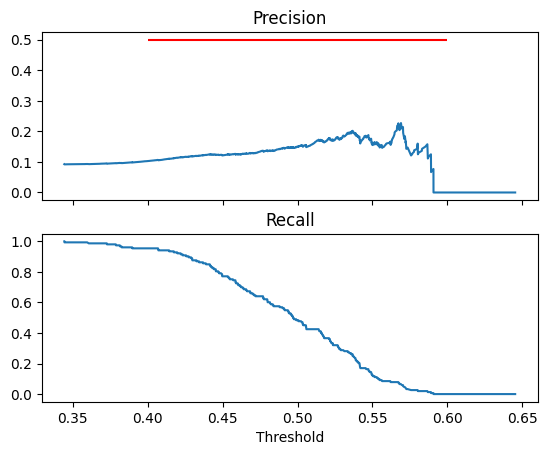

In [884]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0.4, xmax=0.6, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

In [887]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.1][0]
print(min_index)

193


In [888]:
thresholds[min_index]

0.39361168803635216

In [889]:
precision[min_index]

0.1

In [890]:
recall[min_index]

0.954248366013072

In [891]:
f1_score(y_test, preds, labels=["No", "Yes"], pos_label="Yes")


0.22945736434108527

In [892]:
rf_model = pipeline.named_steps['classifier']
importances = rf_model.feature_importances_

Feature time_in_hospital: 0.11658418034173305
Feature admission_type_code: 0.07179053223363381
Feature gender: 0.06939625575995187
Feature race: 0.06491717890392744
Feature diag_1: 0.04495576730413445
Feature medical_specialty: 0.04415882117826788
Feature payer_code: 0.035064030743467194
Feature age: 0.024891336545678183
Feature diag_3: 0.01865724586913809
Feature diuretics: 0.01008701063281733
Feature discharge_disposition_code: 0.0088102931291205
Feature has_prosthesis: 0.00827765369722494
Feature complete_vaccination_status: 0.007715217267661637
Feature num_lab_procedures: 0.004482511637694038
Feature admission_source_code: 0.004288991606025249
Feature hemoglobin_level: 0.003808001222574858
Feature diag_2: 0.0030229960941761413
Feature number_outpatient: 0.0019019856705755093
Feature num_medications: 0.0018571080894083086
Feature num_procedures: 0.0
Feature number_emergency: 0.0
Feature number_inpatient: 0.0
Feature number_diagnoses: 0.0
Feature blood_type: 0.0
Feature blood_transfu

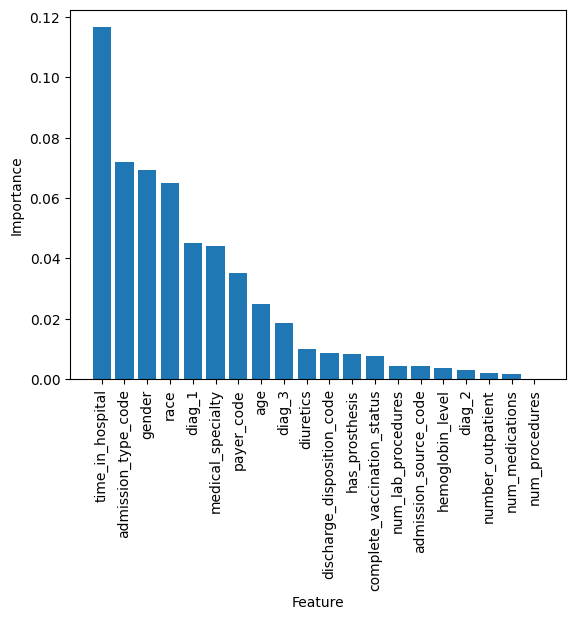

In [893]:
importances = []
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    importances.append((feature, importance))

# Sort the importances in descending order
importances = sorted(importances, key=lambda x: x[1], reverse=True)

# Print the feature importances in order
for feature, importance in importances:
    print(f"Feature {feature}: {importance}")

# Get the names of the top 10 features
top_20_features = [importance[0] for importance in importances[:20]]
print("Top 20 Features:", top_20_features)

# Sort the feature importances in descending order
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)
sorted_indices = [X.columns.get_loc(feature) for feature, importance in sorted_importances]

# Plot the top 10 feature importances
plt.bar(range(20), [importance for feature, importance in sorted_importances][:20])
plt.xticks(range(20), [feature for feature, importance in sorted_importances][:20], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
